## Задание 1. Исследование связей между двумя исследуемыми признаками.

**Условие задачи**: По 20 туристическим фирмам были установлены затраты на рекламную компанию и количетсов туристов, воспользовавшихся после ее проведения услугами каждой фирмы.
Определить коэффициент корреляции между исследумыми признаками.


Импортируем необходимые библиотеки.

In [708]:
import pandas as pd
import numpy as np
import math

Создадим DataFrame с используемыми данными.

In [709]:
costs = [5, 5, 7, 8, 9, 10, 11, 12, 13, 14,
         15, 15, 16, 17, 18, 18, 19, 20, 20, 21]
tourists = [720, 750, 800, 820, 800, 880, 950, 820, 900, 950,
            920, 980, 980, 970, 980, 1010, 1100, 1100, 1115, 1100]

df = pd.DataFrame({'costs': costs, 'tourists': tourists})
print(df)

    costs  tourists
0       5       720
1       5       750
2       7       800
3       8       820
4       9       800
5      10       880
6      11       950
7      12       820
8      13       900
9      14       950
10     15       920
11     15       980
12     16       980
13     17       970
14     18       980
15     18      1010
16     19      1100
17     20      1100
18     20      1115
19     21      1100


Рассчитаем коэффициент корреляции.

In [710]:
def get_corr(df: pd.DataFrame, x_name: str, y_name: str) -> float:
    return df.corr()[x_name][y_name]

In [711]:
coef_corr = get_corr(df, df.columns[0], df.columns[1])
print(f'Коэффициент корреляции: {coef_corr:.4f}')

Коэффициент корреляции: 0.9523


Оценим тесноту связи.

In [712]:
corr_coefs = [0.25, 0.44, 0.64, 0.8, 0.9, 1]
closeness = ['очень слабая', 'слабая', 'умеренная',
             'сильная', 'весьма сильная', 'очень сильная']

def get_closeness(corr: float) -> str:
    corr = abs(corr)
    if corr < 0 or corr > 1:
        return 'error: corr out of range [-1; 1]'
    for i in range(len(corr_coefs)):
        if corr <= corr_coefs[i]:
            return closeness[i]

In [713]:
print(f'Теснота связи при коэфф. корр. {coef_corr:.4f}: {get_closeness(coef_corr)}')

Теснота связи при коэфф. корр. 0.9523: очень сильная


Рассчитаем t-статистику Стьюдента.

In [714]:
def students_t_test(df: pd.DataFrame, x_name: str, y_name: str) -> float:
    r = get_corr(df, x_name, y_name)
    n = df.shape[0]
    return r * math.sqrt(n-2) / math.sqrt(1 - r ** 2)

In [715]:
st_test = students_t_test(df, df.columns[0], df.columns[1])
print(f't-статистика Стьюдента: {st_test:.4f}')

t-статистика Стьюдента: 13.2404


Сравним полученное значение с критическим.

In [716]:
st_test_crit = 1.734

print(f'Критическое значения критерия Стьюдента в данном случае (табличное значение): {st_test_crit:.4f}')
print(f'Расчетное значение критерия Стьюдента в нашей задаче: {st_test:.4f}')

if st_test >= st_test_crit:
    print('t(расч) >= t(табл) => существует зависимость')
else:
    print('t(расч) < t(табл) => величины независимы')

Критическое значения критерия Стьюдента в данном случае (табличное значение): 1.7340
Расчетное значение критерия Стьюдента в нашей задаче: 13.2404
t(расч) >= t(табл) => существует зависимость


## Задание 2. Построение регрессионной модели.

Импортируем библиотеки.

In [717]:
import matplotlib.pyplot as plt
from typing import Tuple, Callable

Вспомогательные функции для удобного вывода текстовой информации и построения графиков.

In [718]:
linear_format_str = "y = {0:.4f} * x + {1:.4f}"
power_format_str = "y = {0:.4f} * x ^ {1:.4f}"
hyper_format_str = "y = {0:.4f} * x + {1:.4f}"


def print_reg_info(df: pd.DataFrame, x_name: str, y_name: str,
                   format_str: str, a: float, b: float, r=-1.0) -> None:
    coef_corr = get_corr(df, x_name, y_name)
    print(f'Коэффициент корреляции: {coef_corr:.4f}')
    
    if not r < 0:
        print(f'Коэффициент детерминации R2: {r:.4f}')

    print(format_str.format(a, b))

linear_line_func = lambda a, b, i: a * i + b
power_line_func = lambda a, b, i: a * (i ** b)
hyper_line_func = lambda a, b, i: a + b / i

def show_plot(df: pd.DataFrame,
              a: float, b: float,
              line_calc_func: Callable[[float, float, float], float],
              x_name: str, y_name: str,
              xlabel='', ylabel='', title=''):

    line = [line_calc_func(a, b, i) for i in df[x_name]]
    plt.plot(df[x_name], line, 'r')

    plt.scatter(df[x_name], df[y_name])

    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)

    plt.show()


### Способ 1. Ручками.

In [719]:
def hands_regression(df: pd.DataFrame, x_name: str, y_name: str) -> Tuple[float, float]:
    x = df[x_name]
    y = df[y_name]
    n = len(x)
    sum_x = sum(x)
    sum_y = sum(y)
    sum_xy = sum(x * y)
    a = (n * sum_xy - sum_x * sum_y) / \
        (n * (sum([i ** 2 for i in x])) - sum_x ** 2)
    b = 1 / n * sum_y - a / n * sum_x
    return a, b

Коэффициент корреляции: 0.9523
y = 22.5069 * x + 625.0315


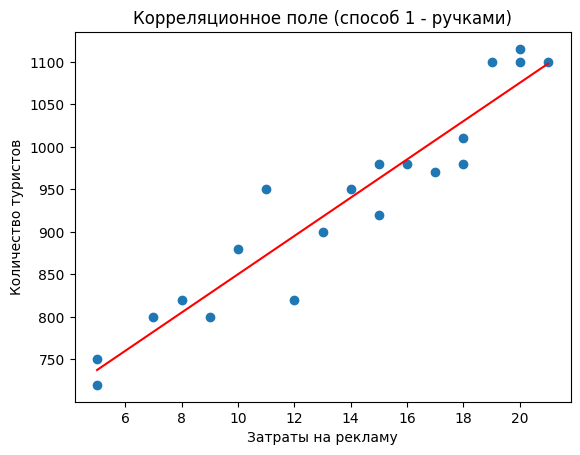

In [720]:
a, b = hands_regression(df, df.columns[0], df.columns[1])

print_reg_info(df, df.columns[0], df.columns[1], linear_format_str, a, b)
show_plot(df, a, b, linear_line_func, df.columns[0], df.columns[1],
          xlabel='Затраты на рекламу', ylabel='Количество туристов',
          title='Корреляционное поле (способ 1 - ручками)')

### Способ 2. Используя библиотеку scikit-learn.

In [721]:
from sklearn import linear_model

# also return R2 coef
def skl_regression(df: pd.DataFrame, x_name: str, y_name: str) -> Tuple[float, float, float]:
    x_data, y_data = df[[x_name]].values, df[y_name].values
    
    reg = linear_model.LinearRegression()
    reg.fit(x_data, y_data)
    
    return (reg.coef_[0], reg.intercept_, reg.score(x_data, y_data),)

Коэффициент корреляции: 0.9523
Коэффициент детерминации R2: 0.9069
y = 22.5069 * x + 625.0315


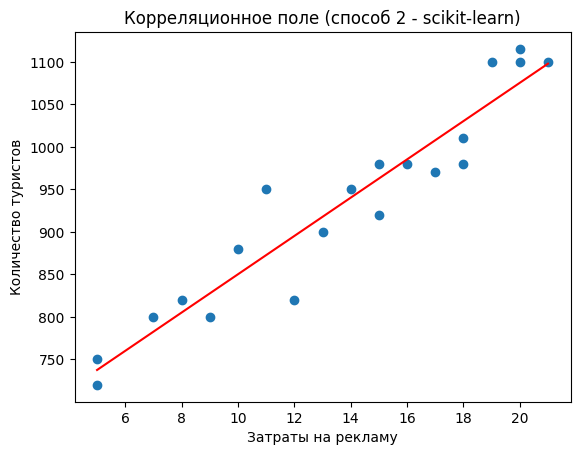

In [722]:
a, b, r = skl_regression(df, df.columns[0], df.columns[1])

print_reg_info(df, df.columns[0], df.columns[1], linear_format_str, a, b, r)
show_plot(df, a, b, linear_line_func, df.columns[0], df.columns[1],
          xlabel='Затраты на рекламу', ylabel='Количество туристов',
          title='Корреляционное поле (способ 2 - scikit-learn)')

### Способ 3. Используя библиотеку numpy.

In [723]:
def np_regression(df: pd.DataFrame, x_name: str, y_name: str) -> Tuple[float, float]:
    x_data, y_data = df[x_name].values, df[y_name].values
    
    fit = np.polyfit(x_data, y_data, 1)
    return (fit[0], fit[1],)

Коэффициент корреляции: 0.9523
y = 22.5069 * x + 625.0315


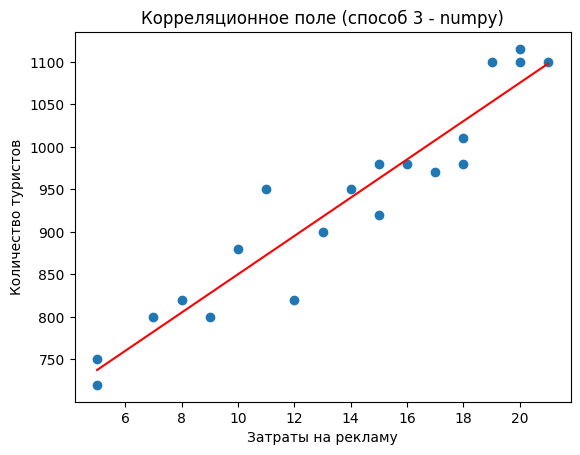

In [724]:
a, b = np_regression(df, df.columns[0], df.columns[1])

print_reg_info(df, df.columns[0], df.columns[1], linear_format_str, a, b)
show_plot(df, a, b, linear_line_func, df.columns[0], df.columns[1],
          xlabel='Затраты на рекламу', ylabel='Количество туристов',
          title='Корреляционное поле (способ 3 - numpy)')

Как видим, результаты применения всех трех разных способов одинаковы.

## Задание 3. Выбор наиболее точной модели.

**Условие задачи.** Исследуется зависимость дозы облучения от толщины слоя защитного материала. Имеются результаты 10 экспериментов.
Имеются основания предполагать, что зависимость дозы (функция) от толщины слоя материала (аругмент) может выражаться одним из следующих уравнений:

* **Y = A0 + A1 * X** (линейная модель)
* **Y = A0 * X ^ A1** (степенная модель)
* **Y = A0 + A1 / X** (гиперболическая модель)

Выберите наиболее точную модель и определите ее коэффициенты.

In [725]:
thickness = [15, 8, 14, 12, 10, 7, 20, 5, 24, 18]
dose = [22, 30, 23, 24, 26, 30, 10, 33, 8, 14]

df = pd.DataFrame({'thickness': thickness, 'dose': dose})
df.sort_values(by=['thickness'], inplace=True)
print(df)

   thickness  dose
7          5    33
5          7    30
1          8    30
4         10    26
3         12    24
2         14    23
0         15    22
9         18    14
6         20    10
8         24     8


### Линейная модель

Коэффициент корреляции: -0.9841
Коэффициент детерминации R2: 0.9685
y = -1.3978 * x + 40.5905


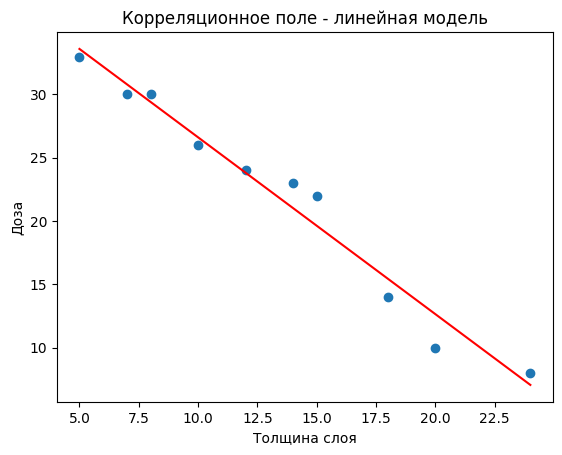

In [726]:
a1, b1, r1 = skl_regression(df, df.columns[0], df.columns[1])

print_reg_info(df, df.columns[0], df.columns[1], linear_format_str, a1, b1, r1)
show_plot(df, a1, b1, linear_line_func, df.columns[0], df.columns[1],
          xlabel='Толщина слоя', ylabel='Доза',
          title='Корреляционное поле - линейная модель')

### Степенная модель.

Для получения степеной модели преобразуем данные используя логарифмирование.

In [727]:
x_name, y_name = df.columns
x_data, y_data = df[x_name].values, df[y_name].values

x_ln_data, y_ln_data = np.log(x_data), np.log(y_data)

df_ln = pd.DataFrame({'x': x_ln_data, 'y': y_ln_data})

a2, b2, r2 = skl_regression(df_ln, df_ln.columns[0], df_ln.columns[1])
a2, b2 = math.exp(b2), a2

Коэффициент корреляции: -0.8929
Коэффициент детерминации R2: 0.7972
y = 177.2008 * x ^ -0.8774


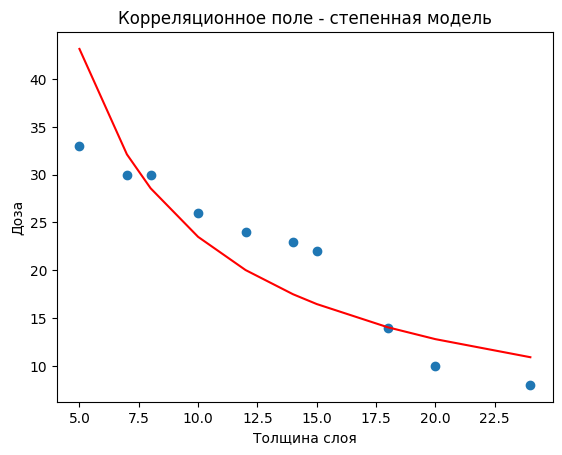

In [728]:
print_reg_info(df_ln, df_ln.columns[0], df_ln.columns[1], power_format_str, a2, b2, r2)
show_plot(df, a2, b2, power_line_func, df.columns[0], df.columns[1],
          xlabel='Толщина слоя', ylabel='Доза',
          title='Корреляционное поле - степенная модель')

### Гиперболическая модель.

Для получения гиперболической модели преобразуем данные по иксу следующим образом: x = 1 / x.

In [729]:
x_name, y_name = df.columns
x_data, y_data = df[x_name].values, df[y_name].values
x_data = 1/x_data

df_h = pd.DataFrame({'x': x_data, 'y': y_data})

a3, b3, r3 = skl_regression(df_h, df_h.columns[0], df_h.columns[1])
a3, b3 = b3, a3

Коэффициент корреляции: 0.8680
Коэффициент детерминации R2: 0.7534
y = 7.8175 * x + 151.4402


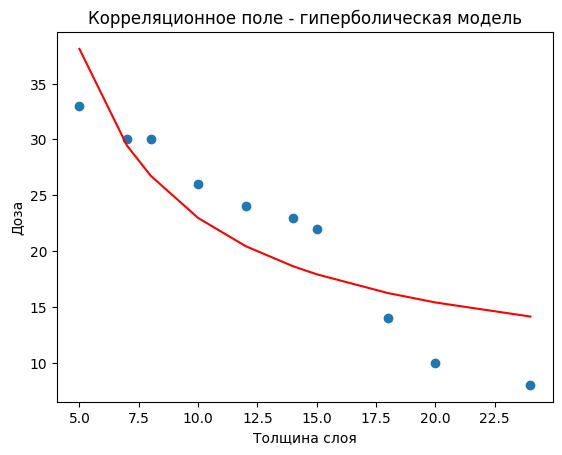

In [730]:
print_reg_info(df_h, df_h.columns[0], df_h.columns[1], hyper_format_str, a3, b3, r3)
show_plot(df, a3, b3, hyper_line_func, df.columns[0], df.columns[1],
          xlabel='Толщина слоя', ylabel='Доза',
          title='Корреляционное поле - гиперболическая модель')

### Сравним модели и сделаем вывод

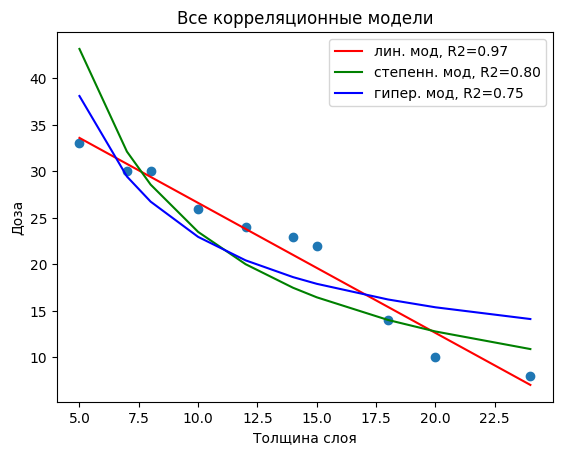

In [731]:
line1 = [linear_line_func(a1, b1, i) for i in df[x_name]]
plt.plot(df[x_name], line1, 'r', label=f'лин. мод, R2={r1:.2f}')

line2 = [power_line_func(a2, b2, i) for i in df[x_name]]
plt.plot(df[x_name], line2, 'g', label=f'степенн. мод, R2={r2:.2f}')

line3 = [hyper_line_func(a3, b3, i) for i in df[x_name]]
plt.plot(df[x_name], line3, 'b', label=f'гипер. мод, R2={r3:.2f}')

plt.scatter(df[x_name], df[y_name])

plt.title('Все корреляционные модели')
plt.xlabel('Толщина слоя')
plt.ylabel('Доза')
plt.legend()

plt.show()

Как видим, линейная модель показала лучший результат, что подтверждают и график, и коэффициент детерминации.

## Задание 4А.

Имеются данные по двум экономическим показателям X и Y. Необходимо:
* Вычислить коэффициент корреляции
* Построить корреляционное поле
* Построить регрессионную модель

In [732]:
cost = [997, 987, 1002, 1012, 1011, 1017, 978, 997, 1010, 989]
demand = [120, 140, 115, 100, 100, 90, 150, 130, 95, 155]

df = pd.DataFrame({'cost': cost, 'demand': demand})
df.sort_values(by=['cost'], inplace=True)
print(df)

   cost  demand
6   978     150
1   987     140
9   989     155
0   997     120
7   997     130
2  1002     115
8  1010      95
4  1011     100
3  1012     100
5  1017      90


Коэффициент корреляции: -0.9552
Коэффициент детерминации R2: 0.9125
y = -1.7690 * x + 1888.4655


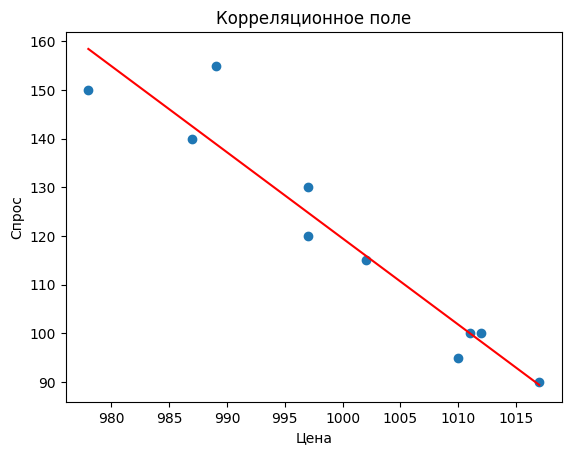

In [733]:
a, b, r = skl_regression(df, *df.columns)

print_reg_info(df, df.columns[0], df.columns[1], linear_format_str, a, b, r)
show_plot(df, a, b, linear_line_func, df.columns[0], df.columns[1],
          xlabel='Цена', ylabel='Спрос',
          title='Корреляционное поле')

## Задание 4Б.

Установить, зависит ли количество посетителей музея и посетителей парка от числа ясных дней за определенный период. Для этого:
* Вычислить коэффициенты корреляции
* Построить корреляционное поле
* Построить регрессионную модель

In [734]:
clear_days = [8, 14, 20, 25, 20, 15]
museum_visitors = [495, 503, 380, 305, 348, 465]
park_visitors = [132, 348, 643, 865, 743, 541]

df = pd.DataFrame({'clear_days': clear_days,
                  'museum_visitors': museum_visitors,
                  'park_visitors': park_visitors})
df.sort_values(by=['clear_days'], inplace=True)
print(df)

   clear_days  museum_visitors  park_visitors
0           8              495            132
1          14              503            348
5          15              465            541
2          20              380            643
4          20              348            743
3          25              305            865


Коэффициент корреляции: -0.9219
Коэффициент детерминации R2: 0.8498
y = -12.8977 * x + 635.2614


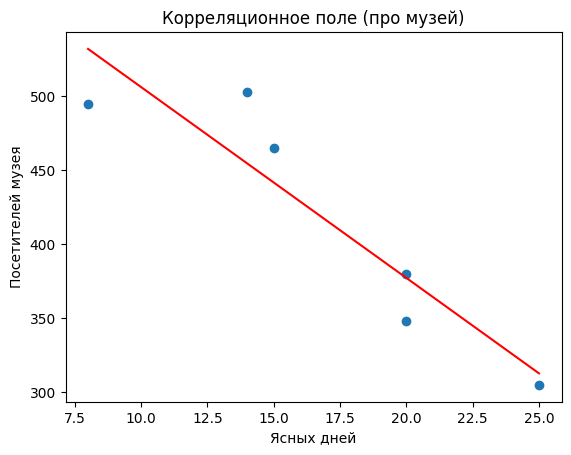

Коэффициент корреляции: 0.9746
Коэффициент детерминации R2: 0.9498
y = 44.1136 * x + -204.5985


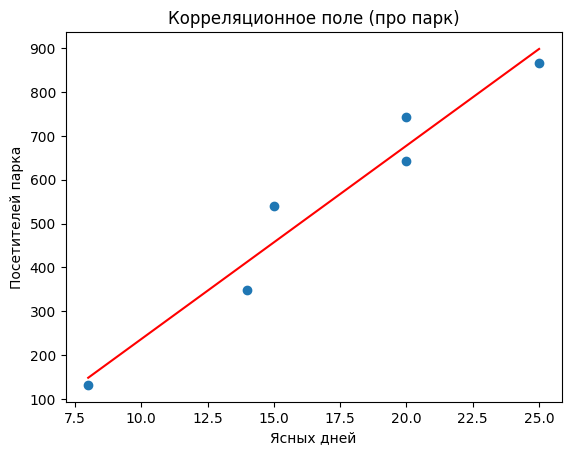

In [739]:
a1, b1, r1 = skl_regression(df, 'clear_days', 'museum_visitors')

print_reg_info(df, 'clear_days', 'museum_visitors', linear_format_str, a1, b1, r1)
show_plot(df, a1, b1, linear_line_func, 'clear_days', 'museum_visitors',
          xlabel='Ясных дней', ylabel='Посетителей музея',
          title='Корреляционное поле (про музей)')

a2, b2, r2 = skl_regression(df, 'clear_days', 'park_visitors')

print_reg_info(df, 'clear_days', 'park_visitors', linear_format_str, a2, b2, r2)
show_plot(df, a2, b2, linear_line_func, 'clear_days', 'park_visitors',
          xlabel='Ясных дней', ylabel='Посетителей парка',
          title='Корреляционное поле (про парк)')

Как видим, имеется очень высокая обратная зависимость между числом ясных дней и количеством посетителей музея, однако прямая зависимость между числом ясных дней и количеством посетителей парка еще немного выше, чему свидетельствуют большие коэффициент корреляции (по модулю) и коэффициент детерминации.